# Kriging and Shapley Value Computation on Event Level

**Author**: Matthew Samuel  
**Date**: June 2025

## Description

This Jupyter Notebook performs Kriging interpolation and data valuation using Shapley values at the **Event level** (Scenario 2). The analysis is conducted using a parallelized framework based on Dask.

For each selected Geohash (target):
- A Kriging prediction is computed using spatially neighboring cells.
- The model then evaluates the contribution of each neighbor through **Shapley values**, approximated using **Truncated Structured Sampling (TSS)**.

The notebook supports **batch processing of multiple target Geohashes**. The final results are compiled into a CSV file and saved in the `/Output` directory.

Additionally, summary plots and graphs are generated at the end to aid in interpretation and visualization of the interpolation and data valuation results.

In [1]:
# imports
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import numpy as np
import config
from dask.distributed import Client
import FrameworkEvent as fw
importlib.reload(fw)
import time
import dask.config
from tqdm import tqdm
from distributed import get_worker
import psutil
import os
import pandas as pd
import json

In [3]:

dask.config.set({
    # Worker-spill: 
    'distributed.worker.memory.spill':     True,
    'distributed.worker.memory.target':    0.5,
    'distributed.worker.memory.terminate': 0.95,
    # Scheduler-spill:
    'distributed.scheduler.memory.spill':     True,
    'distributed.scheduler.memory.target':    0.5,
    'distributed.scheduler.memory.terminate': 0.95,
})

client = Client(n_workers=1, threads_per_worker=1, memory_limit='3.5GB')
config.daskClient = client
print("Dask dashboard:", client.dashboard_link)

Dask dashboard: http://127.0.0.1:8787/status


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
input             = "input/input_data_1m.csv"                   # Path to test data 
missing_geohashes = "input/Madrid_centro_missing_ghashes.csv"   # Path to missing geohashes 
groundtruth       = "input/groundtruth_12m.csv"                 # Path to ground truth 

sel_freq = "1800"                                               # Frequency band (e.g., LTE-1800)


In [6]:
# Scatter heavy objects for Dask
combiner = fw.KrigingDataCombination(input_path=input,missing_geohashes=missing_geohashes,sel_freq="1800")
combiner_fut = client.scatter(combiner, broadcast=True)
val_fn = fw.KrigingValueFunction(ground_truth_path=groundtruth)
val_fn_fut = client.scatter(val_fn, broadcast=True)

In [ ]:
# Build sorted geohashes list by neighbor count
sorted_geohashes = sorted(
    combiner.df1["geohash"].unique(),
    key=lambda gh: len(combiner.get_neighbors(gh)),
    reverse=False
)

# Parameters for selecting target geohashes
empty_geohashes_to_predict = 1  # Number of empty geohashes to predict
target_index = 0                # Starting index in the sorted geohash list


# Determine the target geohashes slice
target_geohashes = sorted_geohashes[
    target_index : target_index + empty_geohashes_to_predict
]

In [22]:
# -------------------------------------------
# 2. Krigging Predictions
# -------------------------------------------

results = []
for target_gh in target_geohashes:
    try:
        # Step 1: Initialize model with target geohash
        model = fw.KrigingModel(combiner, target_geohash=target_gh)  # Target is now explicit

        # Step 2: Make prediction (without getCombinedInput)
        prediction = model.getModelOutput()
        
        if not prediction:
            print(f"⚠️ No prediction possible for {target_gh}")
            continue
            
        # Step 3: Gather basic information about the target
        target_data = combiner.df1[combiner.df1["geohash"] == target_gh].iloc[0]
        
        # Step 4: Store results
        results.append({
            "geohash": target_gh,
            "latitude": target_data["latitude"],
            "longitude": target_data["longitude"],
            "predicted_rsrp": prediction["prediction"],
            "variance": prediction["variance"],
            "neighbors": len(model.neighbors_df)
        })
        
    except Exception as e:
        print(f"❌ Error at {target_gh}: {str(e)}")

In [16]:
print("Variogram params - C0:", model.C0, "C1:", model.C1, "alpha:", model.alpha, "R:", model.R)  # Debug

Variogram params - C0: 5 C1: 106.33319315473324 alpha: 4.6 R: 100


In [23]:
# Show results
if results:
    df_results = pd.DataFrame(results)
    print("                          Prediction results")
    print("------------------------------------------------------------------------")
    print(df_results)
    print("------------------------------------------------------------------------")
else:
    print("\nNo predictions possible - check input data")

                          Prediction results
------------------------------------------------------------------------
    geohash   latitude  longitude  predicted_rsrp    variance  neighbors
0  ezjqh1dt  40.438871  -3.687801      -89.751615   86.350915         25
1  ezjqh1ep  40.439215  -3.687115      -95.082151  103.681430         26
2  ezjqh1sr  40.439215  -3.685398      -95.183553  102.018552         26
------------------------------------------------------------------------


In [ ]:
# --- Helper functions to read out metrics ---
# Worker-side process memory via psutil

def _worker_process_memory():
    return psutil.Process(os.getpid()).memory_info().rss

def measure_worker_memory(client):
    """Return dict(worker_id -> process memory in bytes)."""
    return client.run(_worker_process_memory)

def measure_active_futures(client):
    """Return total number of outstanding futures."""
    return len(client.futures)

# --- Measurements before patch-run ---
mem_before      = measure_worker_memory(client)
futures_before  = measure_active_futures(client)

print("=== before shap ===")
print("Worker process memory :", mem_before)
print("Actieve futures       :", futures_before)


=== before shap ===
Worker process memory : {'tcp://127.0.0.1:62377': 287801344}
Actieve futures       : 2


In [ ]:
# -------------------------------------------
# 3. SHAPLEY
# -------------------------------------------

shapResults = []

for target_gh in target_geohashes:
    print("==============================================")
    print(f"Shapley computation (TSS) for target: {target_gh}")
    print("==============================================")
    print("\n")

    # In Shapley phase, scatter model per target
    model = fw.KrigingModel(combiner, target_gh, use_shapley_mode=True)
    model_fut = client.scatter(model, broadcast=True)

    # Create a new vbdeFramework (with buffering) using futures
    framework = fw.vbdeFramework(
        iCombiner=combiner_fut,
        iModel=model_fut,
        iValueFunction=val_fn_fut,
    )

    # Get all neighboring geohashes
    neighbors_df = combiner.get_neighbors(target_gh)
    neighbor_ghs = neighbors_df['geohash_y'].unique().tolist()

    # Count events per neighbor geohash
    event_counts = combiner.events_df['geohash'].value_counts()

    # TESTING ONLY : exclude top x neighbors with the highest event count
    x = 10  # number of neighbor geohashes to exclude
    top_x_gh = sorted(
        neighbor_ghs,
        key=lambda gh: event_counts.get(gh, 0),
        reverse=True
    )[:x]
    print(f"[TEST] Excluding top {x} neighbors by event count:")
    print(f"{top_x_gh}")
    print("\n")

    # Remaining neighbor geohashes
    used_ghs = [gh for gh in neighbor_ghs if gh not in top_x_gh]

    # Get event IDs for the remaining geohashes
    subindices = combiner.events_df[
        combiner.events_df['geohash'].isin(used_ghs)
    ]['event_id'].tolist()
    if not subindices:
        print("⚠️ No remaining events after exclusion, skipping...\n")
        continue

    # Calculate Shapley values using Truncated Structured Sampling
    r = 20                   # Number of rounds (more rounds = more accurate)
    trunc_value = -0.01      # Truncation threshold for marginal contributions

    shap_start = time.time()
    shapley_tss, dfPerms, nExecs = framework.getTSS_parallel(
        config.daskClient,
        framework.WorkerProcess_init,
        subindices,
        r,
        trunc_value
    )
    runtime = time.time() - shap_start
    print(f"\n[DEBUG] Time for getSV_TSS: {runtime:.2f}s")

    # Evaluate full coalition (–RMSE)
    full_coalition = tuple(sorted(subindices))
    eval_start = time.time()
    prediction_full_eval = framework.evaluateTuple(full_coalition)
    print(f"[DEBUG] Time for evaluateTuple (full coalition): {time.time() - eval_start:.2f}s")

    # Get raw RSRP prediction for the full coalition
    combined_input = combiner.getCombinedInput(target_gh, full_coalition)
    rsrp_prediction = model.getModelOutput(combined_input)["prediction"]

    # Build DataFrame with event-level Shapley values
    event_shap_df = pd.DataFrame({'event_id': subindices})
    event_shap_df['shapley_value'] = event_shap_df['event_id'].map(shapley_tss)

   # Merge with events_df for geohash and event coordinates
    neighbor_shap_df = pd.merge(
        event_shap_df,
        combiner.events_df.rename(columns={
            'value': 'rsrp_value',
            'longitude': 'event_longitude',
            'latitude': 'event_latitude'
        }),
        on='event_id'
    )

    # Select and rename relevant columns, keeping event coords separate
    neighbor_shap_df = neighbor_shap_df[[
        'event_id', 'user_id', 'date', 'geohash', 'event_longitude', 'event_latitude', 'rsrp_value', 'shapley_value'
    ]].rename(columns={'rsrp_value': 'value'})

    # Add neighbor geohash name, center coords, and distance to target
    neighbor_shap_df = neighbor_shap_df.rename(columns={'geohash': 'neighbor_geohash'})
    # Merge to get neighbor geohash center longitude and latitude
    neighbor_centers = combiner.df2[['geohash', 'longitude', 'latitude']].rename(columns={
        'geohash': 'neighbor_geohash',
        'longitude': 'center_longitude',
        'latitude': 'center_latitude'
    })
    neighbor_shap_df = pd.merge(
        neighbor_shap_df,
        neighbor_centers,
        on='neighbor_geohash',
        how='left'
    )
    # Compute distance from each event to the target geohash center
    target_info = combiner.df1[combiner.df1['geohash'] == target_gh].iloc[0]
    target_lon = target_info['longitude']
    target_lat = target_info['latitude']
    neighbor_shap_df['distance_to_target'] = neighbor_shap_df.apply(
        lambda row: combiner.distance_btw_2_coord(
            row['event_latitude'], target_lat,
            row['event_longitude'], target_lon
        ),
        axis=1
    )

    # Display event-level Shapley values
    print("\n")
    print("-" * 41)
    print("Used events and their TSS Shapley values:")
    print(f"{'Event ID':<12} {'Geohash':<12} {'Shapley Value':>15}")
    print("-" * 41)
    for _, row in neighbor_shap_df.iterrows():
        event_id_str = "target" if row['event_id'] is None else str(int(row['event_id']))
        print(f"{event_id_str:<12} {row['neighbor_geohash']:<12} {row['shapley_value']:>15.6f}") 
    print("-" * 41)
    print("\n")

    # Add a row for the target itself
    target_info = combiner.df1[combiner.df1["geohash"] == target_gh].iloc[0]
    target_row = pd.DataFrame([{
        "event_id": None,
        "geohash": target_gh,
        "target_longitude": target_info["longitude"],
        "target_latitude": target_info["latitude"],
        "value": rsrp_prediction,
        "shapley_value": np.nan
    }])
    neighbor_shap_df = pd.concat([neighbor_shap_df, target_row], ignore_index=True)

    

    # Check Shapley efficiency: sum of individual SVs vs. v(N)
    shapsum = neighbor_shap_df['shapley_value'].sum()
    shapsum_rounded = round(shapsum, 3)
    vN_rounded = round(prediction_full_eval, 3)
    sv_check = (shapsum_rounded == vN_rounded)

    print("\nShapley sum vs. v(N):", shapsum_rounded, ",", vN_rounded)
    print("Efficiency check passed:", sv_check)

    # Compute total possible evaluateTuple calls (untruncated)
    total_calls = len(dfPerms) * len(subindices)
    calls_saved = total_calls - nExecs

    # Store results for the current target
    shapResults.append({
        "target_geohash": target_gh,
        "rsrp_prediction": rsrp_prediction,
        "negative RMSE": prediction_full_eval,
        "number_of_neighbors": len(subindices),
        "event_shapley_values": neighbor_shap_df,
        "total_shapley": shapsum,
        "sv_check": sv_check,
        "nExecs": nExecs,
        "nPermutations": len(dfPerms),
        "calls_saved": calls_saved
    })



    print("\n")
    print(f"Number of evaluateTuple calls (nExecs): {nExecs}")
    print(f"Number of permutations generated: {len(dfPerms)}\n")

shapResults_df = pd.DataFrame(shapResults)

Shapley computation (TSS) for target: ezjqh1dt


[TEST] Excluding top 10 neighbors by event count:
['ezjqh1d8', 'ezjqh1dr', 'ezjqh1dp', 'ezjqh19y', 'ezjqh1dw', 'ezjqh1dy', 'ezjqh1dx', 'ezjqh19z', 'ezjqh1f2', 'ezjqh1d1']




Shapley progress: 100%|██████████| 26/26 [04:25<00:00, 10.19s/chunk, avg=10.2s, ETA=0:00:00]



[DEBUG] Time for getSV_TSS: 265.18s
[DEBUG] Time for evaluateTuple (full coalition): 0.00s


-----------------------------------------
Used events and their TSS Shapley values:
Event ID     Geohash        Shapley Value
-----------------------------------------
956          ezjqh1g1            0.447768
957          ezjqh19v           -1.288629
37758        ezjqh1fb           -0.067231
37760        ezjqh1g1           -0.553236
55565        ezjqh1d3           -0.699996
55594        ezjqh1d3           -0.659785
55764        ezjqh1e1           -1.441022
55766        ezjqh1d9           -0.650880
55769        ezjqh1e1           -1.380324
55944        ezjqh1e1           -1.283517
58228        ezjqh1fb            0.382119
58230        ezjqh1g1            0.370233
58915        ezjqh1f1            0.460149
59005        ezjqh1f0            0.286433
136434       ezjqh1dv           -0.008486
143682       ezjqh1fb            0.390820
145072       ezjqh1dz            0.574457
145190       ezjqh1du   

In [14]:
mem_after     = measure_worker_memory(client)
futures_after = measure_active_futures(client)

print("=== after shap ===")
print("Worker process memory :", mem_after)
print("Actieve futures       :", futures_after)
print("Shapley runtime (s)   :", runtime)

=== after shap ===
Worker process memory : {'tcp://127.0.0.1:54392': 571604992, 'tcp://127.0.0.1:54395': 509935616, 'tcp://127.0.0.1:54398': 497319936, 'tcp://127.0.0.1:54401': 518209536, 'tcp://127.0.0.1:54404': 564019200, 'tcp://127.0.0.1:54407': 507805696, 'tcp://127.0.0.1:54410': 530038784, 'tcp://127.0.0.1:54413': 528236544, 'tcp://127.0.0.1:54416': 507822080}
Actieve futures       : 3
Shapley runtime (s)   : 265.18377900123596


In [26]:
shapResults_df = pd.DataFrame(shapResults)
shapResults_df

NameError: name 'shapResults' is not defined

In [ ]:
total_neg_RMSE = shapResults_df["negative RMSE"].sum()
print("Som of all -RMSE:", total_neg_RMSE)

Som van -RMSE: -5.587997932993645


In [ ]:
#Adjust [x] to chose different target
output = shapResults_df["event_shapley_values"][0]
output

,event_id,user_id,date,neighbor_geohash,event_longitude,event_latitude,value,shapley_value,center_longitude,center_latitude,distance_to_target,geohash,target_longitude,target_latitude
0,956,2.0,2024-03-26,ezjqh1g1,-3.686977,40.439578,-104.000000,0.447768,-3.687115,40.439560,105.108043,NaN,NaN,NaN
1,957,3.0,2024-03-26,ezjqh19v,-3.688916,40.438896,-81.000000,-1.288629,-3.688831,40.438873,94.426906,NaN,NaN,NaN
2,37758,357.0,2024-03-17,ezjqh1fb,-3.687306,40.439376,-90.000000,-0.067231,-3.687458,40.439384,70.052642,NaN,NaN,NaN
3,37760,359.0,2024-03-17,ezjqh1g1,-3.686964,40.439586,-86.000000,-0.553236,-3.687115,40.439560,106.523890,NaN,NaN,NaN
4,55565,4.0,2024-03-14,ezjqh1d3,-3.688185,40.438161,-84.000000,-0.699996,-3.688145,40.438187,85.417310,NaN,NaN,NaN
5,55594,15.0,2024-03-14,ezjqh1d3,-3.688046,40.438148,-84.000000,-0.659785,-3.688145,40.438187,83.076053,NaN,NaN,NaN
6,55764,44.0,2024-03-14,ezjqh1e1,-3.687096,40.438120,-77.000000,-1.441022,-3.687115,40.438187,102.754652,NaN,NaN,NaN
7,55766,46.0,2024-03-14,ezjqh1d9,-3.687911,40.438124,-84.000000,-0.650880,-3.687801,40.438187,83.611937,NaN,NaN,NaN
8,55769,49.0,2024-03-14,ezjqh1e1,-3.687203,40.438105,-77.000000,-1.380324,-3.687115,40.438187,99.172741,NaN,NaN,NaN
9,55944,51.0,2024-03-14,ezjqh1e1,-3.686989,40.438115,-77.000000,-1.283517,-3.687115,40.438187,108.671614,NaN,NaN,NaN


In [ ]:
output.to_csv('output/output_shapleyEVENTlevel.csv')

In [ ]:
# This logic makes it able to plot the geohash rectangels in Kepler.gl

_base32 = "0123456789bcdefghjkmnpqrstuvwxyz"
_bits    = [16,8,4,2,1]

def decode_bbox(gh):
    even, lat_range, lon_range = True, [-90.0,90.0], [-180.0,180.0]
    for c in gh:
        cd = _base32.index(c)
        for b in _bits:
            if even:
                mid = (lon_range[0]+lon_range[1])/2
                if cd & b: lon_range[0] = mid
                else:      lon_range[1] = mid
            else:
                mid = (lat_range[0]+lat_range[1])/2
                if cd & b: lat_range[0] = mid
                else:      lat_range[1] = mid
            even = not even
    return lat_range, lon_range

def geohash_to_geojson(gh):
    # skip if not a valid string
    if not isinstance(gh, str) or len(gh)==0:
        return None
    (lat0,lat1),(lon0,lon1) = decode_bbox(gh)
    coords = [
        [lon0, lat0],
        [lon0, lat1],
        [lon1, lat1],
        [lon1, lat0],
        [lon0, lat0]
    ]
    return json.dumps({"type":"Polygon","coordinates":[coords]})


df = output

df['_geojson'] = df['neighbor_geohash'].apply(geohash_to_geojson)
df.to_csv('output/output_with_rects.csv', index=False)

***Graphing***

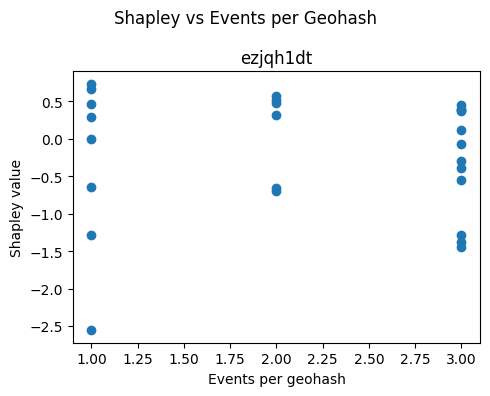

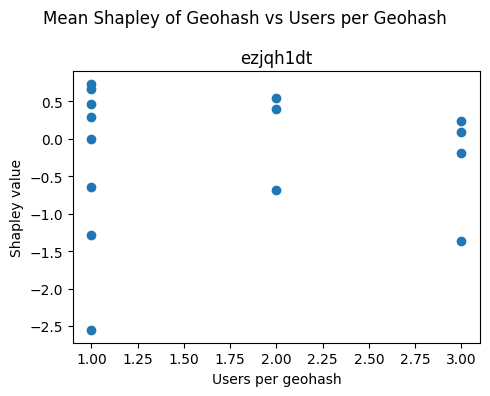

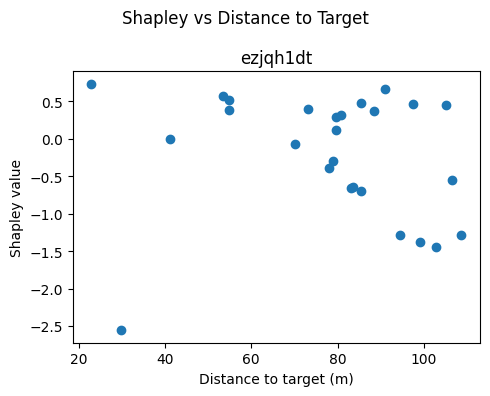

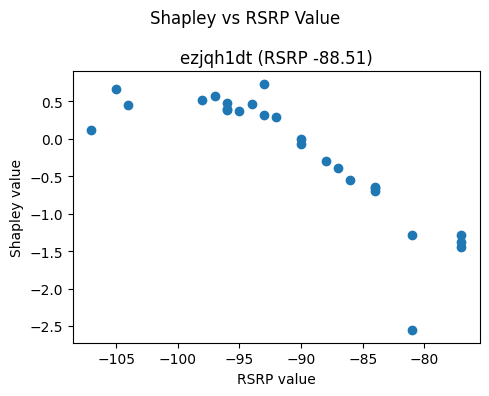

In [25]:
# Next steps: X-Y plots of Shapley value against various features per missing geohash

# Precompute events per geohash
events_count = combiner.events_df['geohash'].value_counts()


try:
    raw_df = pd.read_csv(input)
    if 'user_id' in raw_df.columns:
        user_counts = raw_df.groupby('gps_geohash_08')['user_id'].nunique()
    else:
        user_counts = combiner.df2.set_index('geohash')['events']
except Exception:
    user_counts = combiner.df2.set_index('geohash')['events']

# Plot configurations: (feature, xlabel, title, include_rsrp_in_label)
plot_configs = [
    ('events_per_geohash', 'Events per geohash', 'Shapley vs Events per Geohash', False),
    ('users_per_geohash',    'Users per geohash',  'Mean Shapley of Geohash vs Users per Geohash',  False),
    ('distance_to_target',  'Distance to target (m)', 'Shapley vs Distance to Target', False),
    ('value',               'RSRP value',         'Shapley vs RSRP Value',         True),
]

for feature, xlabel, title, show_rsrp in plot_configs:
    # Create one subplot per missing geohash
    n_targets = len(shapResults_df)
    fig, axes = plt.subplots(1, n_targets, figsize=(5 * n_targets, 4), squeeze=False)
    for ax, (_, row) in zip(axes[0], shapResults_df.iterrows()):
        df = row['event_shapley_values']
        # Determine x- and y-values
        if feature == 'events_per_geohash':
            x = df['neighbor_geohash'].map(events_count)
            y = df['shapley_value']
        elif feature == 'users_per_geohash':
            # Aggregate mean Shapley per neighbor geohash
            agg = df.groupby('neighbor_geohash')['shapley_value'] \
                     .mean().reset_index(name='mean_shapley')
            x = agg['neighbor_geohash'].map(user_counts)
            y = agg['mean_shapley']
        else:
            x = df[feature]
            y = df['shapley_value']
        ax.scatter(x, y)
        # Title per subplot
        label = row['target_geohash']
        if show_rsrp:
            label += f" (RSRP {row['rsrp_prediction']:.2f})"
        ax.set_title(label)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Shapley value')
    # Overall title
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()



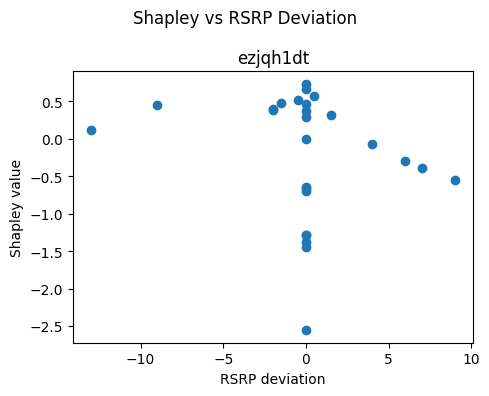

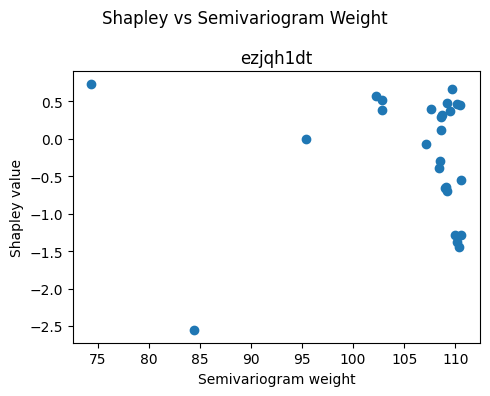

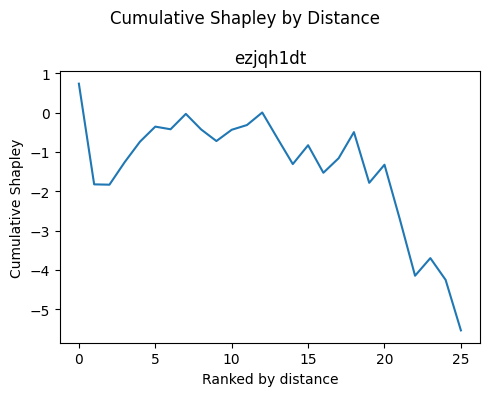

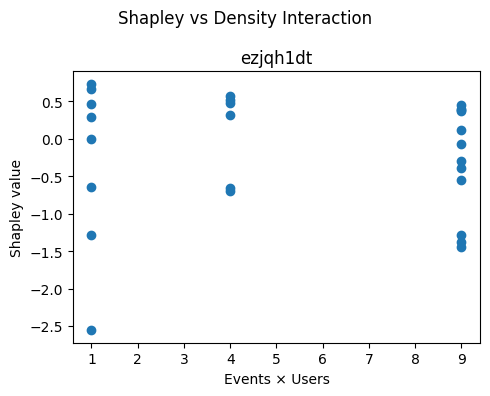

In [26]:
# ------------------------------------------------------------
# Additional diagnostic plots
# ------------------------------------------------------------

# 1. Shapley vs RSRP deviation from geohash mean
n = len(shapResults_df)
fig, axes = plt.subplots(1, n, figsize=(5*n, 4), squeeze=False)
gh_mean = combiner.df2.set_index('geohash')['value']
for ax, (_, row) in zip(axes[0], shapResults_df.iterrows()):
    df = row['event_shapley_values']
    deviation = df['value'] - df['neighbor_geohash'].map(gh_mean)
    ax.scatter(deviation, df['shapley_value'])
    ax.set_title(row['target_geohash'])
    ax.set_xlabel("RSRP deviation")
    ax.set_ylabel("Shapley value")
fig.suptitle("Shapley vs RSRP Deviation")
plt.tight_layout()
plt.show()

# 2. Shapley vs semivariogram weight
fig, axes = plt.subplots(1, n, figsize=(5*n, 4), squeeze=False)
for ax, (_, row) in zip(axes[0], shapResults_df.iterrows()):
    df = row['event_shapley_values']
    weight = combiner.sv(df['distance_to_target'])
    ax.scatter(weight, df['shapley_value'])
    ax.set_title(row['target_geohash'])
    ax.set_xlabel("Semivariogram weight")
    ax.set_ylabel("Shapley value")
fig.suptitle("Shapley vs Semivariogram Weight")
plt.tight_layout()
plt.show()


# 3. Cumulative Shapley contribution by distance
fig, axes = plt.subplots(1, n, figsize=(5*n, 4), squeeze=False)
for ax, (_, row) in zip(axes[0], shapResults_df.iterrows()):
    df = row['event_shapley_values'].sort_values('distance_to_target')
    cumsum = df['shapley_value'].cumsum()
    ax.plot(cumsum.values)
    #x = range(1, len(cumsum) + 1)
    #ax.scatter(x, cumsum.values)
    ax.set_title(row['target_geohash'])
    ax.set_xlabel("Ranked by distance")
    ax.set_ylabel("Cumulative Shapley")
fig.suptitle("Cumulative Shapley by Distance")
plt.tight_layout()
plt.show()

# 4. Shapley vs density interaction (events × users)
events_count = combiner.events_df['geohash'].value_counts()
try:
    raw_df = pd.read_csv(input)
    if 'user_id' in raw_df.columns:
        user_counts = raw_df.groupby('gps_geohash_08')['user_id'].nunique()
    else:
        user_counts = combiner.df2.set_index('geohash')['events']
except:
    user_counts = combiner.df2.set_index('geohash')['events']
fig, axes = plt.subplots(1, n, figsize=(5*n, 4), squeeze=False)
for ax, (_, row) in zip(axes[0], shapResults_df.iterrows()):
    df = row['event_shapley_values']
    density = df['neighbor_geohash'].map(events_count) * df['neighbor_geohash'].map(user_counts)
    ax.scatter(density, df['shapley_value'])
    ax.set_title(row['target_geohash'])
    ax.set_xlabel("Events × Users")
    ax.set_ylabel("Shapley value")
fig.suptitle("Shapley vs Density Interaction")
plt.tight_layout()
plt.show()



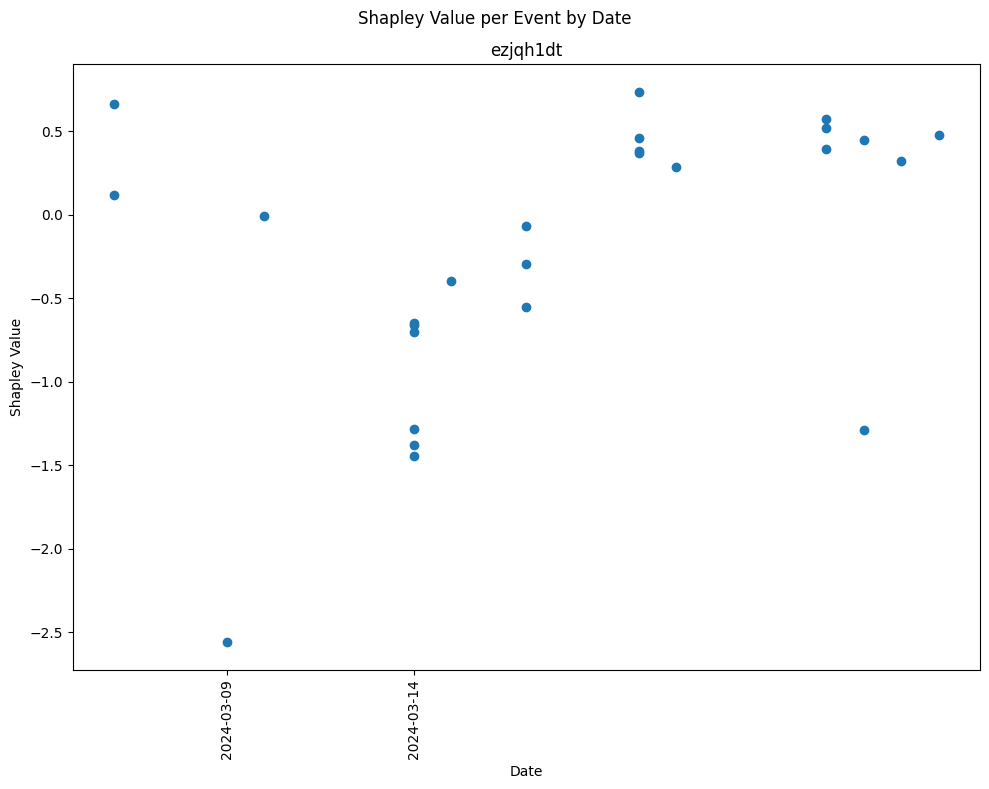

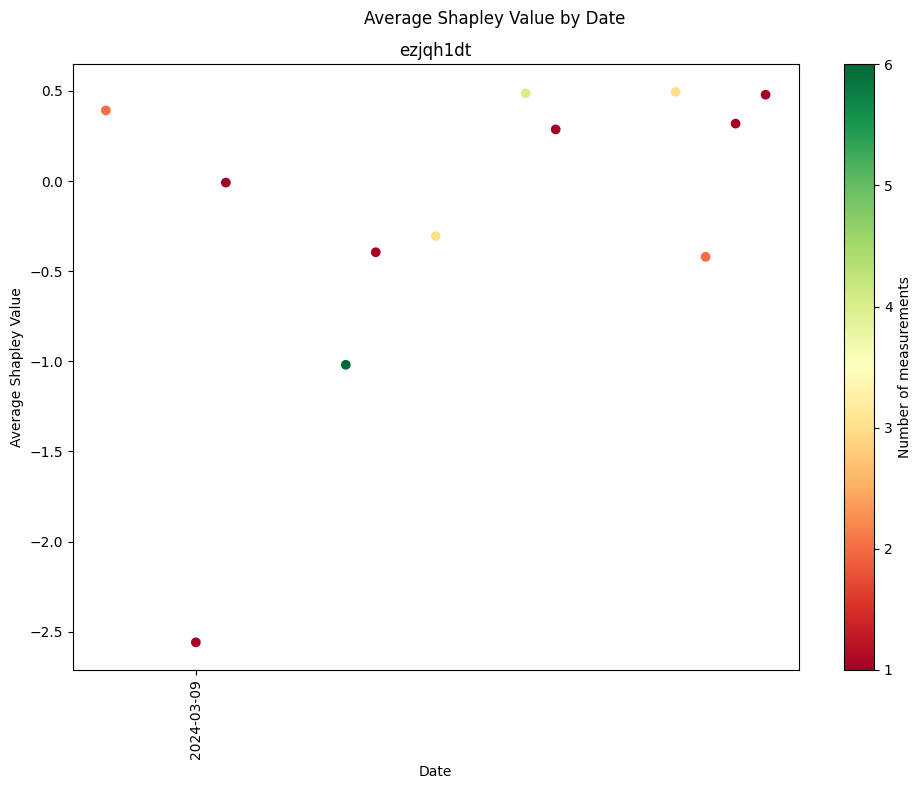

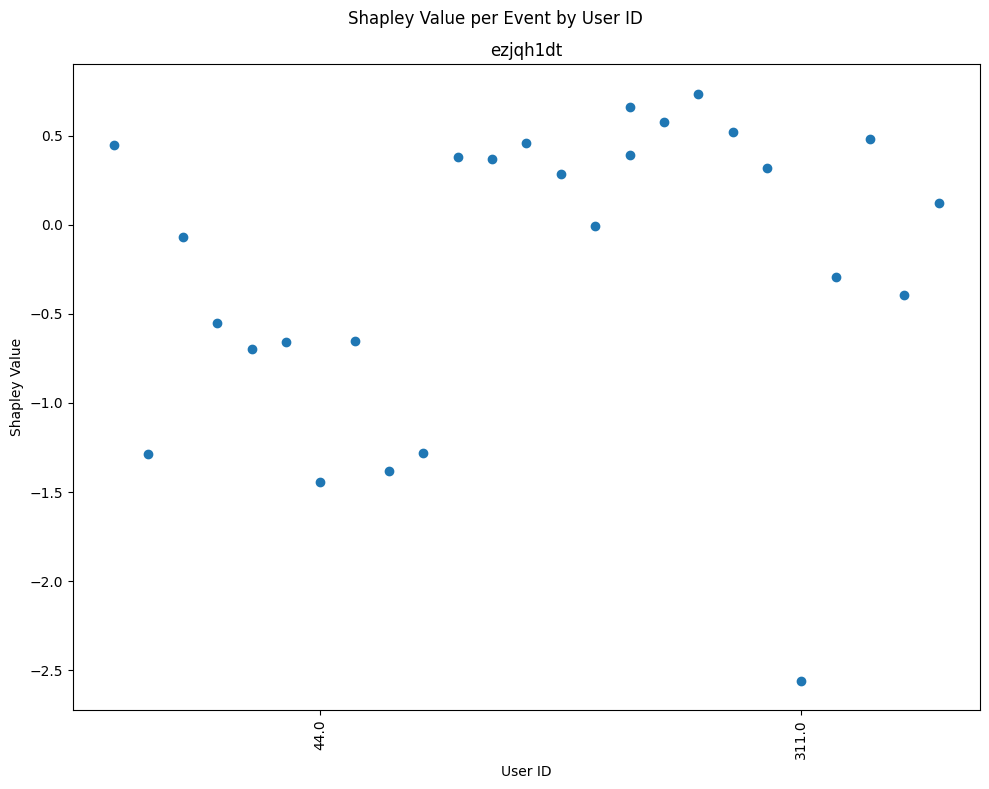

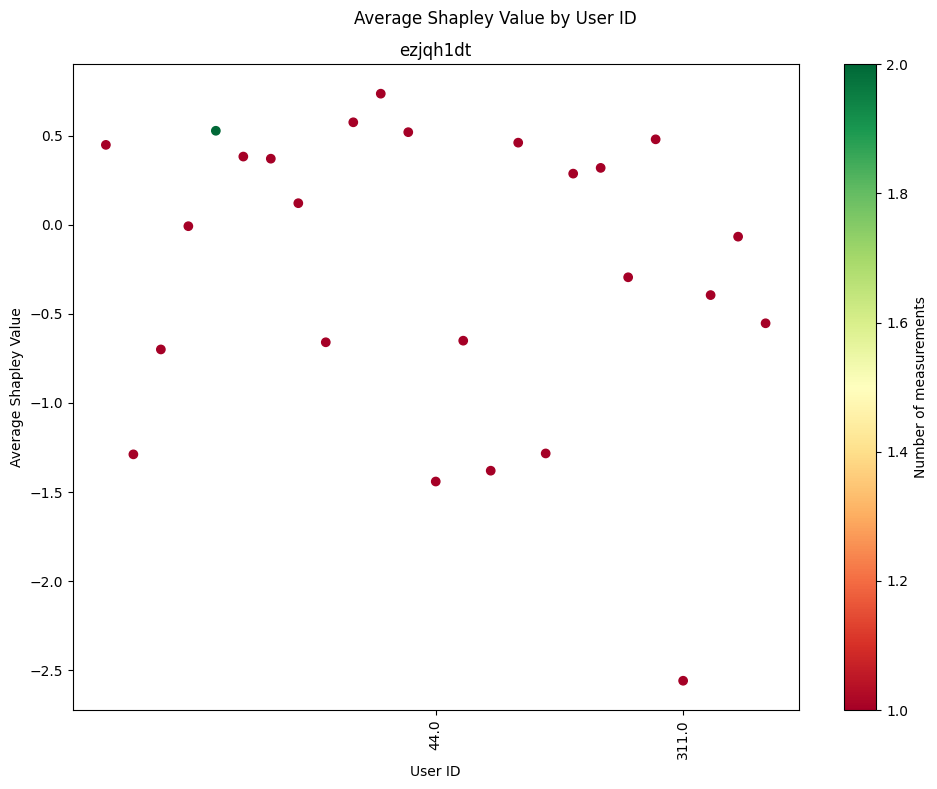

In [27]:
# -----------------------------------------------------------------------------
# Shapley vs Date and User
# -----------------------------------------------------------------------------

# Number of targets
n = len(shapResults_df)

# 1. Shapley vs Date per event
fig, axes = plt.subplots(1, n, figsize=(10*n, 8), squeeze=False)
for ax, (_, row) in zip(axes[0], shapResults_df.iterrows()):
    df = row['event_shapley_values'].copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    ax.scatter(df['date'], df['shapley_value'])
    ax.set_title(row['target_geohash'])
    ax.set_xlabel('Date')
    ax.set_ylabel('Shapley Value')
    # Label only the lowest 5% Shapley events
    low = df['shapley_value'].quantile(0.05)
    outlier_dates = df.loc[df['shapley_value'] < low, 'date'].unique()
    ax.set_xticks(outlier_dates)
    ax.set_xticklabels([d.strftime('%Y-%m-%d') for d in outlier_dates], rotation=90)
fig.suptitle('Shapley Value per Event by Date')
plt.tight_layout()
plt.show()

# 2. Average Shapley vs Date
fig, axes = plt.subplots(1, n, figsize=(10*n, 8), squeeze=False)
for ax, (_, row) in zip(axes[0], shapResults_df.iterrows()):
    df = row['event_shapley_values'].copy()
    df['date'] = pd.to_datetime(df['date'])
    mean_by_date = df.groupby('date')['shapley_value'].mean().reset_index()
    count_by_date = df.groupby('date').size().reset_index(name='count')
    mean_by_date = mean_by_date.merge(count_by_date, on='date')
    counts = mean_by_date['count']
    norm = plt.Normalize(vmin=counts.min(), vmax=counts.max())
    colors = plt.cm.RdYlGn(norm(counts))
    ax.scatter(mean_by_date['date'], mean_by_date['shapley_value'], c=colors)
    ax.set_title(row['target_geohash'])
    ax.set_xlabel('Date')
    ax.set_ylabel('Average Shapley Value')
    # Label only the lowest 5% average Shapley
    low = mean_by_date['shapley_value'].quantile(0.05)
    outlier_dates = mean_by_date.loc[mean_by_date['shapley_value'] < low, 'date']
    ax.set_xticks(outlier_dates)
    ax.set_xticklabels([d.strftime('%Y-%m-%d') for d in outlier_dates], rotation=90)
fig.suptitle('Average Shapley Value by Date')
plt.tight_layout()
# Add color legend for measurement counts
mappable = plt.cm.ScalarMappable(norm=norm, cmap='RdYlGn')
mappable.set_array([])
fig.colorbar(mappable, ax=axes, orientation='vertical', label='Number of measurements')
plt.show()

# 3. Shapley vs User ID per event
fig, axes = plt.subplots(1, n, figsize=(10*n, 8), squeeze=False)
for ax, (_, row) in zip(axes[0], shapResults_df.iterrows()):
    df = row['event_shapley_values']
    # Treat user IDs as categorical, equal spacing
    user_ids = df['user_id'].unique()
    user_to_idx = {uid: i for i, uid in enumerate(user_ids)}
    x = df['user_id'].map(user_to_idx)
    ax.scatter(x, df['shapley_value'])
    ax.set_title(row['target_geohash'])
    ax.set_xlabel('User ID')
    ax.set_ylabel('Shapley Value')
    # Label only the lowest 5% as outliers
    low = df['shapley_value'].quantile(0.05)
    outlier_ids = df.loc[df['shapley_value'] < low, 'user_id'].unique()
    outlier_positions = [user_to_idx[uid] for uid in outlier_ids]
    # Only label outlier positions
    ax.set_xticks(outlier_positions)
    ax.set_xticklabels(outlier_ids, rotation=90)
fig.suptitle('Shapley Value per Event by User ID')
plt.tight_layout()
plt.show()

# 4. Average Shapley vs User ID
fig, axes = plt.subplots(1, n, figsize=(10*n, 8), squeeze=False)
for ax, (_, row) in zip(axes[0], shapResults_df.iterrows()):
    df = row['event_shapley_values']
    mean_by_user = df.groupby('user_id')['shapley_value'].mean().reset_index()
    count_by_user = df.groupby('user_id').size().reset_index(name='count')
    mean_by_user = mean_by_user.merge(count_by_user, on='user_id')
    user_ids = mean_by_user['user_id'].tolist()
    x = list(range(len(user_ids)))
    counts = mean_by_user['count']
    norm = plt.Normalize(vmin=counts.min(), vmax=counts.max())
    colors = plt.cm.RdYlGn(norm(counts))
    # Label only the lowest 5% of mean values
    low = mean_by_user['shapley_value'].quantile(0.05)
    outlier_ids = mean_by_user.loc[mean_by_user['shapley_value'] < low, 'user_id'].tolist()
    outlier_positions = [i for i, uid in enumerate(user_ids) if uid in outlier_ids]
    ax.scatter(x, mean_by_user['shapley_value'], c=colors)
    ax.set_title(row['target_geohash'])
    ax.set_xlabel('User ID')
    ax.set_ylabel('Average Shapley Value')
    # Only label outlier positions
    ax.set_xticks(outlier_positions)
    ax.set_xticklabels(outlier_ids, rotation=90)
fig.suptitle('Average Shapley Value by User ID')
plt.tight_layout()
# Add color legend for measurement counts
mappable = plt.cm.ScalarMappable(norm=norm, cmap='RdYlGn')
mappable.set_array([])
fig.colorbar(mappable, ax=axes, orientation='vertical', label='Number of measurements')
plt.show()
